In [1]:
# setup
# file
import os

# Data Processing
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler

# model
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# explain
import seaborn as sns
import shap

# folder
folder_input = '02_input'



Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# import data
cleaned_data = pd.read_csv(os.path.join('..', folder_input, 'cleaned_data.csv'))


In [3]:
# train vs test
# seperate target from predictors
X = cleaned_data.copy()            # use copy, not to affect original dataset
y = X.pop('Churn')        # y = "churn", and delete churn from X

# train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [4]:
# preprocessing for categorical data
cleaned_data.info()

# select categorical columns
# PS: [categorical_cols] mean == True
categorical_cols = X_train.dtypes == 'object'
categorical_cols = list(categorical_cols[categorical_cols].index)  
categorical_cols    

# categogical encoder
# PS: The output is a series, need to turn to dataframe
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
# cat_encoder = OrdinalEncoder()
cat_cols_train = pd.DataFrame(cat_encoder.fit_transform(X_train[categorical_cols]))
cat_cols_test = pd.DataFrame(cat_encoder.fit_transform(X_test[categorical_cols]))

# One-hot encoding removed index; put it back
cat_cols_train.index = X_train.index
cat_cols_test.index = X_test.index

# add back colnames
cat_cols_train.columns = cat_encoder.get_feature_names_out()
cat_cols_test.columns = cat_encoder.get_feature_names_out()


# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(categorical_cols, axis=1)
num_X_test = X_test.drop(categorical_cols, axis=1)

# Add one-hot encoded columns to numerical features
X_train = pd.concat([num_X_train, cat_cols_train], axis=1)
X_test = pd.concat([num_X_test, cat_cols_test], axis=1)


X_train.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Churn                  7043 non-null   bool   
 1   gender                 7043 non-null   object 
 2   SeniorCitizen          7043 non-null   int64  
 3   Partner                7043 non-null   object 
 4   Dependents             7043 non-null   object 
 5   FamilySize             7043 non-null   int64  
 6   PhoneService           7043 non-null   object 
 7   MultipleLines          7043 non-null   object 
 8   InternetService        7043 non-null   object 
 9   Is_Internet            7043 non-null   int64  
 10  OnlineSecurity         7043 non-null   object 
 11  OnlineBackup           7043 non-null   object 
 12  DeviceProtection       7043 non-null   object 
 13  TechSupport            7043 non-null   object 
 14  StreamingTV            7043 non-null   object 
 15  Stre

NameError: name 'cat_encoder' is not defined

In [ ]:
# preprocessing for numerical data
numericial_cols = cleaned_data.select_dtypes(include=['int64', 'float64']).columns

#scaler
num_encoder = MinMaxScaler()
num_cols_train = pd.DataFrame(num_encoder.fit_transform(X_train[numericial_cols]))
num_cols_test = pd.DataFrame(num_encoder.fit_transform(X_test[numericial_cols]))

#encoding removed index; put it back
num_cols_train.index = X_train.index
num_cols_test.index = X_test.index

# add back colnames
num_cols_train.columns = num_encoder.get_feature_names_out()
num_cols_test.columns = num_encoder.get_feature_names_out()

# Remove numerical  columns (will replace with encoding)
cat_X_train = X_train.drop(numericial_cols, axis=1)
cat_X_test = X_test.drop(numericial_cols, axis=1)

# Add one-hot encoded columns to numerical features
X_train = pd.concat([cat_X_train, num_cols_train], axis=1)
X_test = pd.concat([cat_X_test, num_cols_test], axis=1)


X_train.head()



,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,PaperlessBilling,PaymentMethod,Contract,SeniorCitizen,FamilySize,Is_Internet,tenure,MonthlyCharges,MonthlyChargesPerHead,Is_Contract_Locked
3296,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,1.0,2.0,0.0,0.0,0.0,1.0,0.263889,0.661692,0.698354,0.0
6397,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,2.0,0.0,1.0,1.0,1.000000,0.529353,0.156162,1.0
6043,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,1.0,2.0,0.0,0.0,1.0,1.0,0.847222,0.804975,0.238321,0.0
5309,0.0,1.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,...,0.0,1.0,2.0,0.0,1.0,0.0,0.472222,0.066667,0.018241,1.0
3000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,2.0,0.0,0.0,1.0,0.986111,0.355224,0.424292,1.0


In [ ]:
# xgboost
xgbmodel = XGBClassifier(n_estimators = 1000, random_state=0,scale_pos_weight=5)
xgbmodel.fit(
    X_train,
    y_train
)

# prediction
preds = xgbmodel.predict(X_test)

In [ ]:
# evaluation
accuracy_score(y_test, preds)

0.7830777967064169

In [ ]:
# confusion matrix
confusion_matrix(y_test, preds)

array([[1138,  165],
       [ 217,  241]], dtype=int64)

In [ ]:
# classification report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

       False       0.84      0.87      0.86      1303
        True       0.59      0.53      0.56       458

    accuracy                           0.78      1761
   macro avg       0.72      0.70      0.71      1761
weighted avg       0.78      0.78      0.78      1761



<Axes: >

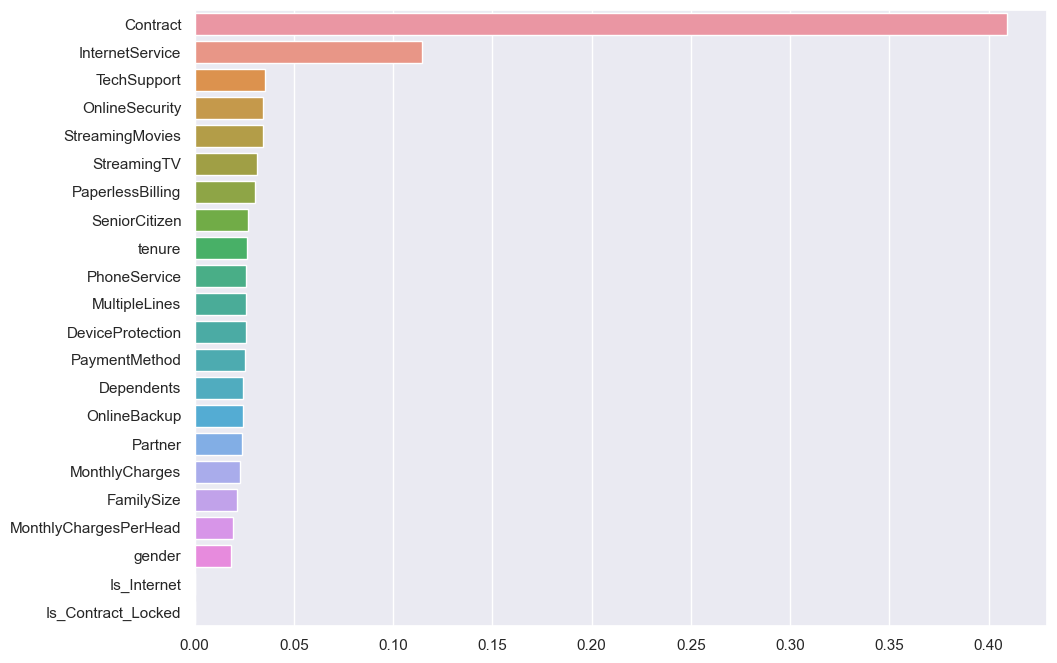

In [ ]:
# feature importance
xgb_importance = pd.Series(xgbmodel.feature_importances_, index=X_train.columns).sort_values(ascending= False)
xgb_importance

# plot it
sns.set(rc={'figure.figsize':(11,8)})
sns.barplot(x = xgb_importance.values,
            y = xgb_importance.index)